## All you need is love… And a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
You can drop entries with missing values.

In [39]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)



In [40]:
original_data[['outcome_type']].sample(10)

,outcome_type
71316,Euthanasia
63913,Transfer
69852,Transfer
31004,Adoption
18979,Transfer
24095,Adoption
34936,Transfer
42552,Return to Owner
56380,Adoption
42483,Transfer


In [41]:
data_animals = original_data.copy()
print('The size of the dataframe with na values is: {}'.format(len(data_animals)))
data_animals.dropna(inplace=True) # by putting in place True, the removal is done on the dataframe data_animals
print('The size of the dataframe without na values is: {}'.format(len(data_animals)))

The size of the dataframe with na values is: 79672
The size of the dataframe without na values is: 79661


In [42]:
# Now we want to create a new column which has 1 if adopted and 0 otherwise
# data_animals['adopted'] = np.where(data_animals['outcome_type']== 'Adoption', 1, 0)
# data_animals.sample(10)
# data_animals.dtypes

data_animals['adopted'] = data_animals.outcome_type.apply(lambda r: 1 if r=='Adoption' else 0)
data_animals.drop("outcome_type", axis = 1, inplace=True)

In [43]:
# Now we can split the data into training and testing set
# Method provided, not trying to understand why it works

def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

In [44]:
[train, test] = split_set(data_animals)

In [45]:
# Now all the categorical features need to be converted into dummy variables: outcome_type, sex_upon_outcome, animal_type, intake_condition, intake_type, sex_upon_intake
categorical_columns = ['sex_upon_outcome', 'animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake']
train_categorical = pd.get_dummies(train, columns=categorical_columns) # we specify which columns need to be taken into account for creating the dummy variables
train_categorical.columns

Index(['age_upon_outcome_(years)', 'age_upon_intake_(years)', 'intake_year',
       'intake_number', 'time_in_shelter_days', 'adopted',
       'sex_upon_outcome_Intact Female', 'sex_upon_outcome_Intact Male',
       'sex_upon_outcome_Neutered Male', 'sex_upon_outcome_Spayed Female',
       'sex_upon_outcome_Unknown', 'animal_type_Bird', 'animal_type_Cat',
       'animal_type_Dog', 'animal_type_Other', 'intake_condition_Aged',
       'intake_condition_Feral', 'intake_condition_Injured',
       'intake_condition_Normal', 'intake_condition_Nursing',
       'intake_condition_Other', 'intake_condition_Pregnant',
       'intake_condition_Sick', 'intake_type_Euthanasia Request',
       'intake_type_Owner Surrender', 'intake_type_Public Assist',
       'intake_type_Stray', 'intake_type_Wildlife',
       'sex_upon_intake_Intact Female', 'sex_upon_intake_Intact Male',
       'sex_upon_intake_Neutered Male', 'sex_upon_intake_Spayed Female',
       'sex_upon_intake_Unknown'],
      dtype='object')

### The features in the testing set must be matched with the training set.

In [46]:
# Make sure we use only the features available in the training set
test_categorical = pd.get_dummies(test, columns=categorical_columns)[train_categorical.columns] # we make sure that we use the features that are also in the training set for accurate results

In [47]:
# Training set
train_label=train_categorical.adopted # the label will be adopted or not meaning the y
train_features = train_categorical.drop('adopted', axis=1) # the features will be all the other columns which corresponds to the X
print('Length of the train dataset : {}'.format(len(train)))

# Testing set
test_label=test_categorical.adopted
test_features = test_categorical.drop('adopted', axis=1)
print('Length of the test dataset : {}'.format(len(test)))

Length of the train dataset : 63735
Length of the test dataset : 15926


In [48]:
means = train_features.mean()
stddevs = train_features.std()

train_features_std = pd.DataFrame()
for c in train_features.columns:
    train_features_std[c] = (train_features[c]-means[c])/stddevs[c] # Standardisation of the features !!!!!!!

# Use the mean and stddev of the training set !!!! Very important to standardise testing set with the training mean and std
test_features_std = pd.DataFrame()
for c in test_features.columns:
    test_features_std[c] = (test_features[c]-means[c])/stddevs[c]

train_features_std.head()

,age_upon_outcome_(years),age_upon_intake_(years),intake_year,intake_number,time_in_shelter_days,sex_upon_outcome_Intact Female,sex_upon_outcome_Intact Male,sex_upon_outcome_Neutered Male,sex_upon_outcome_Spayed Female,sex_upon_outcome_Unknown,animal_type_Bird,animal_type_Cat,animal_type_Dog,animal_type_Other,intake_condition_Aged,intake_condition_Feral,intake_condition_Injured,intake_condition_Normal,intake_condition_Nursing,intake_condition_Other,intake_condition_Pregnant,intake_condition_Sick,intake_type_Euthanasia Request,intake_type_Owner Surrender,intake_type_Public Assist,intake_type_Stray,intake_type_Wildlife,sex_upon_intake_Intact Female,sex_upon_intake_Intact Male,sex_upon_intake_Neutered Male,sex_upon_intake_Spayed Female,sex_upon_intake_Unknown
0,2.714102,2.732441,1.198817,-0.280054,-0.384836,-0.363786,-0.370938,1.346204,-0.68826,-0.305079,-0.064982,-0.76697,0.868824,-0.242576,-0.063877,-0.034324,-0.230897,0.371512,-0.156515,-0.043793,-0.02344,-0.201591,-0.056386,-0.483438,-0.258078,0.652803,-0.213918,-0.650848,-0.681709,2.297657,-0.404734,-0.305079
1,1.677926,1.693833,-1.102656,1.917316,-0.368990,-0.363786,-0.370938,1.346204,-0.68826,-0.305079,-0.064982,-0.76697,0.868824,-0.242576,-0.063877,-0.034324,-0.230897,0.371512,-0.156515,-0.043793,-0.02344,-0.201591,-0.056386,-0.483438,3.874737,-1.531833,-0.213918,-0.650848,-0.681709,2.297657,-0.404734,-0.305079
2,1.332535,1.347630,-1.102656,4.114685,-0.372431,-0.363786,-0.370938,1.346204,-0.68826,-0.305079,-0.064982,-0.76697,0.868824,-0.242576,-0.063877,-0.034324,-0.230897,0.371512,-0.156515,-0.043793,-0.02344,-0.201591,-0.056386,-0.483438,3.874737,-1.531833,-0.213918,-0.650848,-0.681709,2.297657,-0.404734,-0.305079
3,2.714102,2.732441,-1.102656,-0.280054,-0.281431,-0.363786,-0.370938,1.346204,-0.68826,-0.305079,-0.064982,-0.76697,0.868824,-0.242576,-0.063877,-0.034324,-0.230897,0.371512,-0.156515,-0.043793,-0.02344,-0.201591,-0.056386,2.068485,-0.258078,-1.531833,-0.213918,-0.650848,-0.681709,2.297657,-0.404734,-0.305079
4,4.786453,4.809658,-1.869813,-0.280054,-0.395898,-0.363786,-0.370938,1.346204,-0.68826,-0.305079,-0.064982,-0.76697,0.868824,-0.242576,-0.063877,-0.034324,4.330863,-2.691660,-0.156515,-0.043793,-0.02344,-0.201591,-0.056386,-0.483438,3.874737,-1.531833,-0.213918,-0.650848,-0.681709,2.297657,-0.404734,-0.305079


### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

In [49]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): # function to compute the confusion matrix
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix): # function for plotting the confusion matrix
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5): # computing the scores precision, accuracy, recall and f1
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [51]:
# The fitting a regression model
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std,train_label)

LogisticRegression(max_iter=10000)

In [52]:
# computing the probabilities which are used in the function above
prediction_proba = logistic.predict_proba(test_features_std)

Text(0.5, 1.0, 'Confusion matrix for a 0.5 threshold')

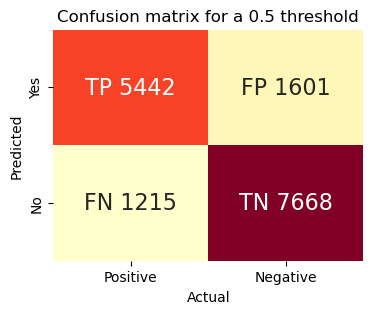

In [53]:
confusion_matrix_05 = compute_confusion_matrix(test_label, prediction_proba, 0.5 )
plt.figure(figsize = (4,3)) 
ax = plot_confusion_matrix(confusion_matrix_05)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for a 0.5 threshold')

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall, and F1-score (with respect to both classes) as a function of the threshold.

In [54]:
threshold = np.linspace(0, 1, 100)

In [55]:
columns_score_name = ['Threshold', 'Accuracy', 'Precision P', 'Recall P', 'F1 score P', \
                                              'Precision N', 'Recall N', 'F1 score N']
threshold_score = pd.concat([pd.DataFrame([compute_all_score(compute_confusion_matrix(test_label, prediction_proba, t ),t)]\
                                             , columns=columns_score_name) for t in threshold], ignore_index=True)
threshold_score.set_index('Threshold', inplace=True)

Text(0.5, 1.0, 'Accuracy')

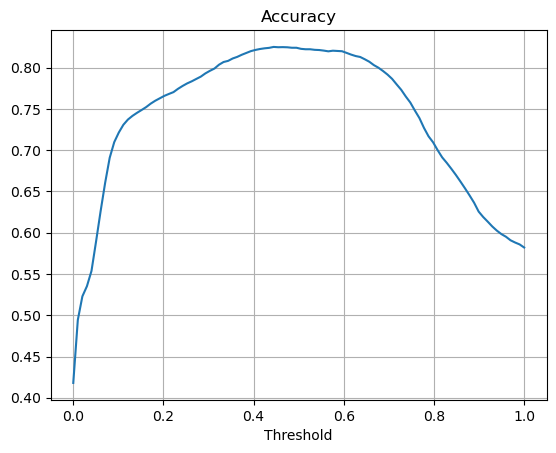

In [56]:
threshold_score['Accuracy'].plot(grid=True).set_title('Accuracy')

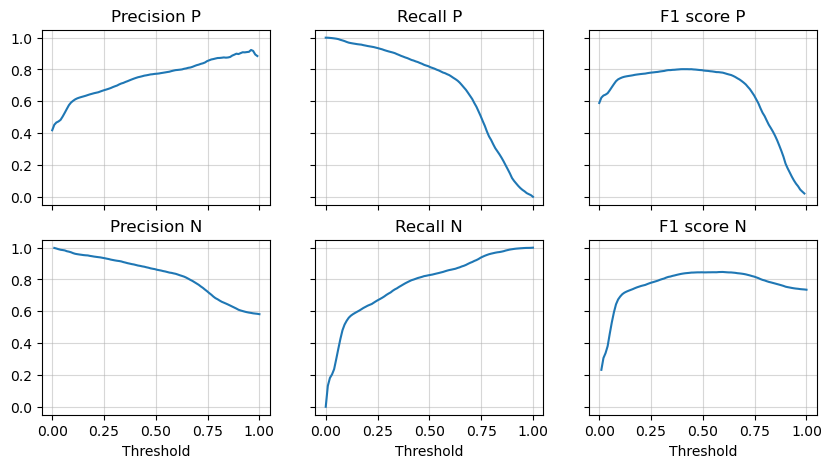

In [57]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))

col_plot = ['Precision P', 'Recall P', 'F1 score P', 'Precision N', 'Recall N', 'F1 score N']

major_ticks = np.linspace(0,1,5)

for axe, col in zip(axs.flat, col_plot):
    threshold_score[col].plot(ax=axe, grid = True)
    axe.set_title(col)
    axe.set_xticks(major_ticks)    
    axe.grid(which='major', alpha=0.5)

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

In [58]:
logistic = LogisticRegression(solver='lbfgs', max_iter=10000)
logistic.fit(train_features_std, train_label)

LogisticRegression(max_iter=10000)

In [59]:
tmp = []
for name, value in zip(train_features_std.columns, logistic.coef_[0]):
    tmp.append({"name": name, "value": value})
    
features_coef = pd.DataFrame(tmp).sort_values("value")
features_coef.head()

,name,value
1,age_upon_intake_(years),-1.777789
26,intake_type_Wildlife,-0.797015
6,sex_upon_outcome_Intact Male,-0.774727
5,sex_upon_outcome_Intact Female,-0.689466
31,sex_upon_intake_Unknown,-0.488723


<BarContainer object of 32 artists>

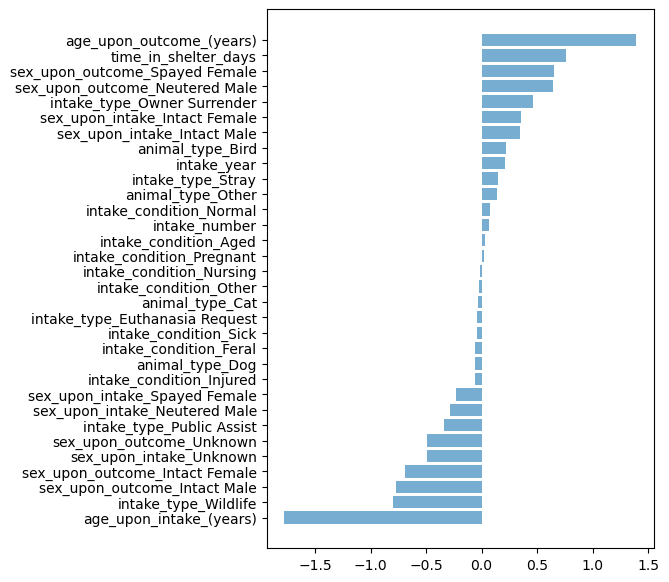

In [60]:
plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)

In [ ]:
# Here we can see that the feature that contributes the most positively to adoption is the age upon outcome
# On the other hand, age unpon intake is an indicator that contributes negatively to adoption

# Tasks done in this Tutorial
1. Creating dummy variables for categorical data
2. Changing outcome to only binary i.e. adopted or not
3. Splitting manually without using a function into training and testing
4. Standardizing the training data and testing data
5. Training a logistic regression model
6. Computing all the scores (accruacy, precision, recall, F1 score) for positive and negative class
7. Plotting a confusion matrix
8. Varying the value of the threshold of the probability for which the prediction will be considered positive
9. Plotting the scores in function of the threshold
10. Extracing the values of all the coefficients of the features considered in the logistic regression
11. Plotting the scores in descending order



## Question 1: Which of the following metrics is most suitable when you are dealing with unbalanced classes?

- a) F1 Score
- b) Recall
- c) Precision
- d) Accuracy

## Question 2: You are working on a binary classification problem. You trained a model on a training dataset and got the following confusion matrix on the test dataset. What is true about the evaluation metrics (rounded to the second decimal point):

|            | Pred = NO|Pred=YES|
|------------|----------|--------|
| Actual NO  |    50    |   10   |
| Actual YES |    5     |   100  |

- a) Accuracy is 0.95
- b) Accuracy is 0.85
- c) False positive rate is 0.95
- d) True positive rate is 0.95